In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [4]:
dots = Path('D:/Datasets/DotsSmall')

In [ ]:
dots

WindowsPath('D:/Datasets/DotsSmall')

In [ ]:
images, lbl_bbox = get_annotations(dots/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [ ]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    samples = [s for s in samples if s[1].data[0].shape[0] > 0] # check that labels are available

    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        bboxes[i,-len(lbls):] = bbs
        labels[i,-len(lbls):] = lbls
    return torch.cat(imgs,0), (bboxes,labels)

In [ ]:
data = (ObjectItemList.from_folder(dots)
        #Where are the images? -> in coco
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=256)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=64, collate_fn=bb_pad_collate, num_workers=1))
        #Finally we convert to a DataBunch and we use bb_pad_collate

In [ ]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

In [ ]:
n_classes = 2
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes, n_anchors=1, sizes=[16], chs=64)
model.eval()

In [ ]:
x = torch.randn(2,3,256,256)
output = model(x)

In [ ]:
print([y.size() for y in output[:2]], output[2])

In [ ]:
ratios = [1]

In [ ]:
scales = [0.1]

In [ ]:
sizes = [(16, 16)]# [(32, 32),(16, 16), (8, 8), (4, 4), (2, 2)]

In [ ]:
anchors = create_anchors(sizes, ratios, scales)

In [ ]:
anchors

In [ ]:
anchors.size()

In [ ]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [ ]:
learn = Learner(data, model, loss_func=crit)

In [ ]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


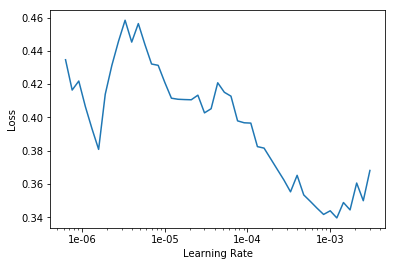

In [87]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

In [106]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss
1,1.011301,1.017521
2,1.078452,0.984077
3,1.079763,1.019912
4,1.064749,1.003747
5,1.062173,1.025224
6,1.036151,1.087355
7,1.029055,1.011483
8,1.007599,0.940765
9,0.979494,0.944182
10,0.980653,0.944316


In [100]:
classes = data.train_ds.classes

In [101]:
classes

['background', 'Border', 'Dots']

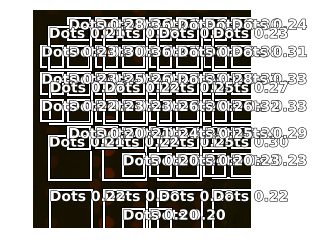

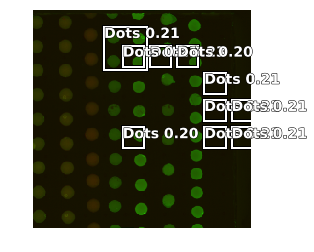

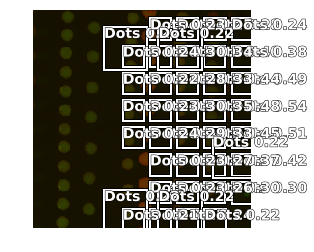

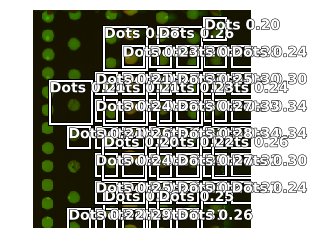

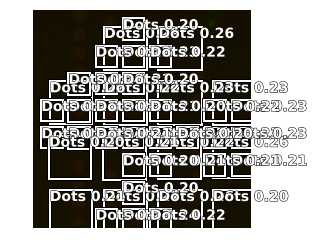

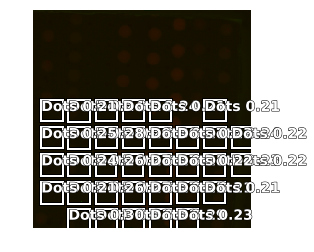

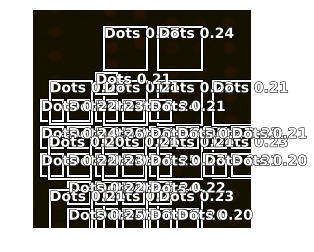

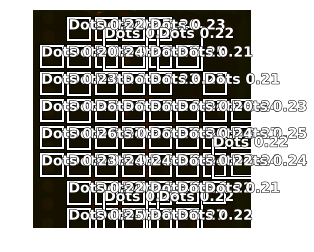

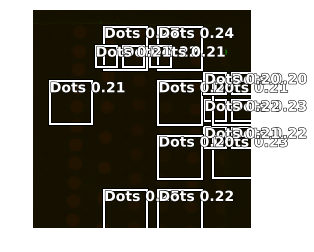

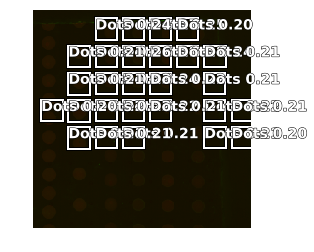

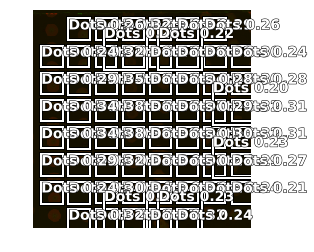

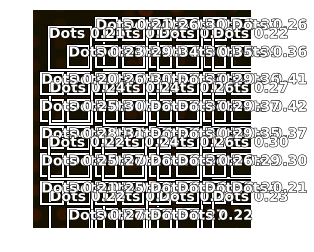

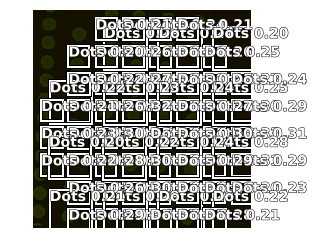

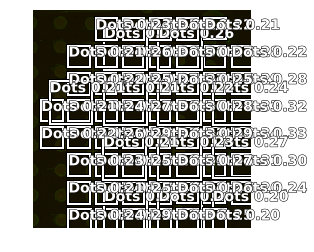

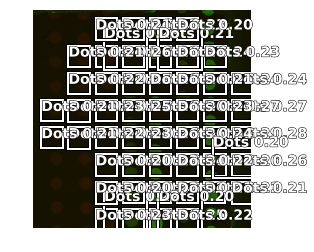

In [105]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = model(img)
    for idx in range(len(output[0])):
        img = data.valid_ds[idx][0] 
        clas_pred = output[0][idx]
        bbox_pred = output[1][idx]

        bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, 0.2)
        if bbox_pred is None:
            continue
            
        to_keep = nms(bbox_pred, scores, 0.1)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2
        bbox_pred[:, :2] = (bbox_pred[:, :2] + 1) * t_sz / 2
        bbox_pred[:, 2:] = bbox_pred[:, 2:] * t_sz
        bbox_pred = bbox_pred.long()

        show_preds(img, bbox_pred, preds, scores, classes)